# Examining Conceptual Behavior in V+L Models

In [1]:
from pathlib import Path
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
import torch
from torchmetrics.functional import accuracy, coverage_error, recall

from fsk.config import layers, feature_types, multi_models_info
from fsk.dataprep.utils import get_synsets_ids, get_fsk, get_fsk_features, get_feature_idx_map
from fsk.it_match.load import get_match, get_concept_match_distance, get_feature_match_distance
from fsk.similarity.sem_distances import get_mcrae_features

To run locally, define the directory containing the project's data:

In [3]:
project_path =  []

In [5]:
res_path = project_path / 'results'
rsa_path = res_path / 'rsa'

In [6]:
# Load synsets and concepts
# synsets_imgs, concepts = get_synsets_ids(project_path / 'dataset')
# concepts_things = concepts['things']
# synsets = list(synsets_imgs.keys())
# synset_concept_map = {s: c for s, c in zip(synsets, concepts_things)}
# # Load semantic feature data
# fsk_info = get_fsk(project_path / 'dataset')
# sem_ft = get_fsk_features(project_path / 'dataset')
# sem_ft_idx = get_feature_idx_map(project_path / 'dataset/annotations')
# r_sem_ft_idx = {val: key for key, val in sem_ft_idx.items()}
# sem_ft_type = {f: f_t for f, f_t in zip(fsk_info['features'], fsk_info['features_type'])}
# sem_ft_idx_by_type = {
#     ft: list(set(fsk_info.loc[fsk_info['features_type']== ft]['features_idx'])) 
#     for ft in feature_types if ft is not None
# }
# synset_features = {s: fsk_info.loc[fsk_info['synsets'] == s]['features'].tolist() for s in synsets}

In [314]:
# Define models
models = ['clip', 'vilt', 'albef']
features_order = ['taxonomic', 'visual_perceptual', 'function', 'encyclopaedic', 'other_perceptual']

In [317]:
# Create an array with the colors you want to use
models_colors = ["#70AC99", "#BA8A49", "#A46882"]
models_palette = sns.set_palette(sns.color_palette(models_colors))

### 1) Is the representational space of concepts V+L models different from their unimodal counterparts?

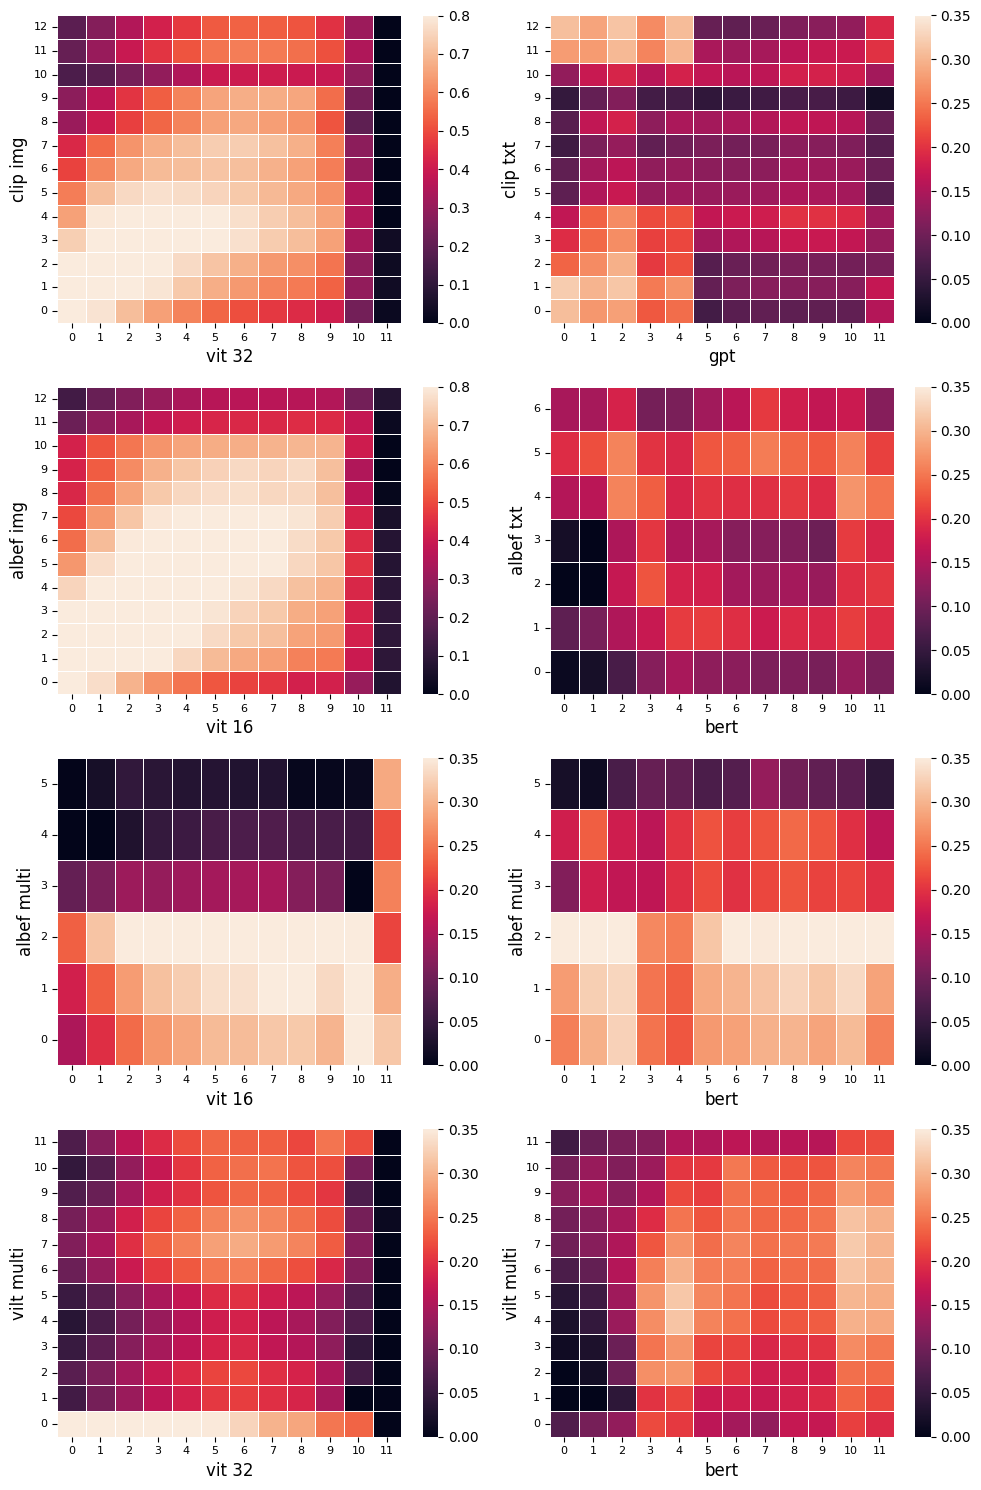

In [9]:
net_map = [
    ['clip_img', 'vit_32'], ['clip_txt', 'gpt'], 
    ['albef_img', 'vit_16'], ['albef_txt', 'bert'],
    ['albef_multi', 'vit_16'], ['albef_multi', 'bert'],
    ['vilt_multi', 'vit_32'], ['vilt_multi', 'bert']
]
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
for ms, ax in zip(net_map, axes.flat):
    file = rsa_path / f'{ms[0]}_{ms[1]}.pkl'
    with open(file, 'rb') as f:
        dist = pickle.load(f)
    dist = pd.DataFrame(dist, columns=['model1', 'model2', 'corr', 'pval'])
    dist['model1'] = dist['model1'].apply(lambda x: ('-').join(x.split('-')[1:]))
    dist['model2'] = dist['model2'].apply(lambda x: ('-').join(x.split('-')[1:]))
    dist = dist.pivot(index='model1', columns='model2', values='corr')
    cols = layers[ms[1]]
    rows = layers[ms[0]]
    dist = dist[cols]
    #dist = dist.columns.set_names('ja')
    dist = dist.reindex(rows)
    
    if 'img' in ms[0]:
        vmin = 0
        vmax = 0.8
    else:
        vmin=0
        vmax=0.35
    sns.heatmap(
        dist, linewidth=.5, 
        vmin=vmin, vmax=vmax, 
        ax=ax
    )
    ax.set_xlabel(f"{(' ').join(ms[1].split('_'))}", size=12)
    ax.set_xticklabels(np.arange(0,len(cols)), rotation=0, size=8)
    ax.set_yticklabels(np.arange(0,len(rows)), rotation=0, size=8)
    ax.set_ylabel(f"{(' ').join(ms[0].split('_'))}", size=12)
    ax.invert_yaxis()
plt.tight_layout()
plt.show()
fig.savefig(project_path / 'figures/net_sim.png', dpi=300)

In [80]:
from itertools import combinations

ms = net_map[0]
#for ms in net_map:
file = rsa_path / f'{ms[0]}_{ms[1]}.pkl'
with open(file, 'rb') as f:
    dist = pickle.load(f)
dist = pd.DataFrame(dist, columns=['model1', 'model2', 'corr', 'pval'])
dist['model1'] = dist['model1'].apply(lambda x: ('-').join(x.split('-')[1:]))
dist['model2'] = dist['model2'].apply(lambda x: ('-').join(x.split('-')[1:]))
dist = dist.drop('pval', axis=1).set_index(['model1', 'model2'])
#dist.stack().to_frame().loc[(['hs_0','hs_1']), :]
#.xs(('hs_0', 'hs_1'), level='model1')

# Full mean
dist_info = [dist.mean()[0]]

# First level is multimodal, second level is unimodal
i = 0
for i in range(4):
    dist_info.append(dist.loc[([f'hs_{i}', f'hs_{i+1}', f'hs_{i+2}']), :].mean()[0])
    i += 3

dist_info

[0.5295737634292248,
 0.5954691669759161,
 0.653514500464893,
 0.6670392018965464,
 0.6580492403332406]

### 2) Are V+L able to lexicalize categories?

In [214]:
synsets_imgs, concepts = get_synsets_ids(project_path / 'dataset')
synsets = list(synsets_imgs.keys())
top_k = [1, 5, 10]

c_preds = {}
for m in models:
    c_match, c_labels = get_match(res_path, m, synsets_imgs, center=True, avg=False, return_np=False)
    m_preds = []
    c_match_path = res_path / m / 'concept_match'
    i = 0
    for s, s_imgs in synsets_imgs.items():
        correct_val = synsets.index(s)
        for img in s_imgs:
            val = [s, img]
            i_pred = c_match[i]
            i = i + 1
            top_indices = i_pred.topk(15)[1]
            val.append([synsets[i] for i in top_indices])
            for t in top_k:
                val.append(correct_val in top_indices[:t])
            m_preds.append(val)
    c_preds[m] = pd.DataFrame(m_preds, columns=['synset', 'image', 'preds', 'top1', 'top5', 'top10'])
    print(m)
    print(f"Top1 accuracy: {c_preds[m]['top1'].mean()}")
    print(f"Top5 accuracy: {c_preds[m]['top5'].mean()}")
    print(f"Top10 accuracy: {c_preds[m]['top10'].mean()}")
    print("\n")

c_preds = (
    pd.concat(c_preds)
    .reset_index(level=1, drop=True)
    .reset_index()
    .rename(columns={'index':'model'})
)

clip
Top1 accuracy: 0.8301542207792207
Top5 accuracy: 0.9659090909090909
Top10 accuracy: 0.9831574675324676


vilt
Top1 accuracy: 0.5186688311688312
Top5 accuracy: 0.7719155844155844
Top10 accuracy: 0.8398944805194806


albef
Top1 accuracy: 0.8110795454545454
Top5 accuracy: 0.948051948051948
Top10 accuracy: 0.9638798701298701




__TO-DO__: select some examples to show (look for errors)

In [ ]:
# i = 0
# for s, s_len in zip(synsets, s_lens):
#     c_match, c_labels = get_match(res_path, 'clip', synsets_imgs, center=False, avg=False, return_np=False)
#     s_preds = [
#         synsets[s] for s in torch.bincount(c_match[i:i+s_len].topk(10)[1].flatten()).topk(10)[1]
#     ]
#     i += s_len
#     #print(s, s_preds)
#     #print('\n')

### 3) To what extent is the conceptual behavior of V+L models explained by the invariances learned by unimodal vision and language models? & 4) How human like is the conceptual behavior of V+L models?

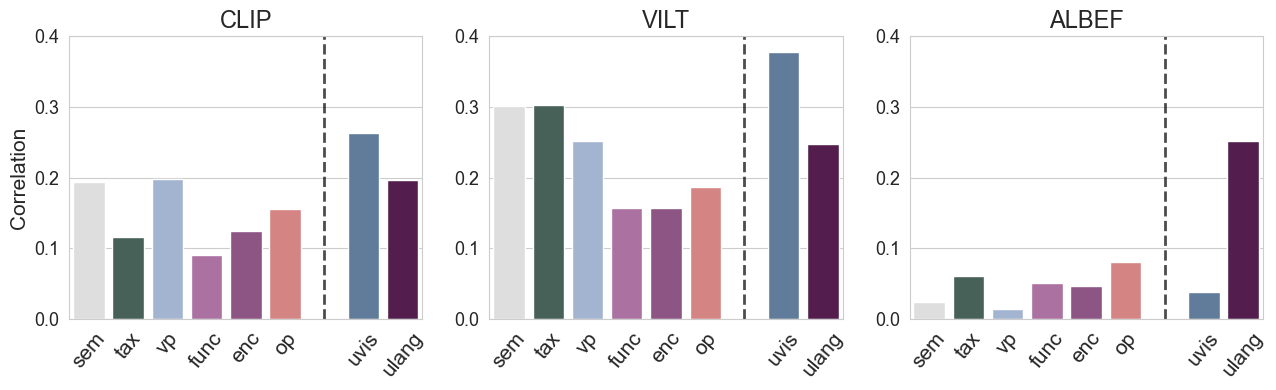

In [312]:
compare = {
    'clip': ['sem_mcrae', 'vit_32', 'gpt'], 
    'vilt':['sem_mcrae', 'vit_32', 'bert'],
    'albef': ['sem_mcrae', 'vit_16', 'bert']
}
labels_order = [
    'sem', 'sem_taxonomic', 'sem_visual_perceptual', 'sem_function', 'sem_encyclopaedic', 
    'sem_other_perceptual', '', 'uvision', 'ulang'
]
labels = ['sem', 'tax', 'vp', 'func', 'enc', 'op', '', 'uvis', 'ulang']

l_colors = ["#DEDEDE", "#43655A", "#9BB2D7", "#B368A7", "#954C8A", "#E37676", "#BEBCBC", "#577AA5", "#5C1554"]
l_palette = sns.set_palette(sns.color_palette(l_colors))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13,4))
for m, ax in zip(models, axes.flat):
    c_res = []
    for c in compare[m]:
        file = res_path / 'rsa' / f'{m}_pred_{c}.pkl'
        with open(file, 'rb') as f:
            res = pickle.load(f)
        res = pd.DataFrame(res, columns=['model', 'comparison_model', 'corr', 'p_val'])
        res['corr'] = - res['corr']
        if 'sem' not in c:
            res = res.loc[res['corr'].idxmax()].to_frame().T
        c_res.append(res)
    c_res = pd.concat(c_res)
    c_res = pd.concat(
        [c_res, 
         pd.DataFrame({'model': ['albef_pred'], 'comparison_model': [''], 'corr': [0], 'pval': [0]})]
    )
    c_res['comparison_model'] = (
        c_res['comparison_model']
        .apply(lambda x: 'uvision' if ('img' in x) else ('ulang' if 'txt' in x else x))
    )
    sns.barplot(
        x='comparison_model', y='corr', order=labels_order, data=c_res, ax=ax, 
        #palette=l_palette
    )
    ax.set(ylim=(0, 0.4))
    ax.set_xlabel(None)
    ax.set_ylabel('Correlation', size=15)
    ax.set_xticklabels(labels, rotation=50, size=15)
    ax.yaxis.set_tick_params(labelsize=13)
    ax.axvline(x = 6, ymin = 0, ymax = 1, color = 'black', linewidth=2, linestyle='dashed', alpha=0.7)
    ax.set_title(f'{m.upper()}', size=17)
for ax in axes.flat[1:]:
   ax.set(ylabel=None)
plt.tight_layout()
plt.show()
fig.savefig(project_path / 'figures/cb_sim.png', dpi=300)

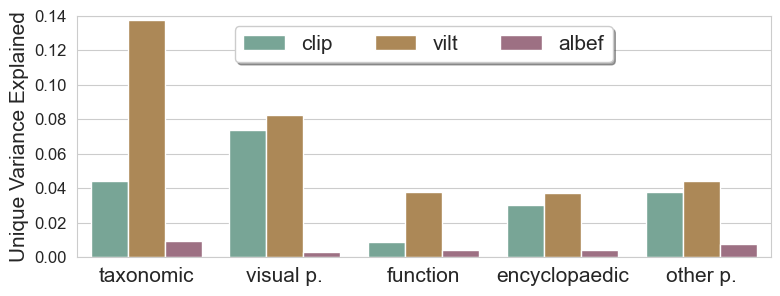

In [319]:
sns.set_style("whitegrid")
pred_var = {}
for m in models:
    m_var = pd.read_csv(project_path / 'results/rsa' / f'pred_var_{m}.csv', index_col=0)
    m_var.index = m_var.index.fillna('all')
    pred_var[m] = m_var
pred_var = pd.concat(pred_var)
pred_var = pred_var.reset_index().rename(columns={'level_0': 'model', 'level_1': 'feature_type', '0': 'r2'})

fig, ax = plt.subplots(figsize=(8,3))
sns.barplot(
    x='feature_type', y='r2', hue='model', data=pred_var, 
    order=features_order, hue_order=models, 
    palette= models_palette
)
ax.set(ylim=(0, 0.14))
ax.set(xlabel=None)
ax.set_ylabel('Unique Variance Explained', size=15)
ax.yaxis.set_tick_params(labelsize=12)
ax.legend(
    loc='upper center', bbox_to_anchor=(0.5, 1),
    ncol=6, fancybox=True, shadow=True, 
    fontsize=15
    #labels=['CLIP', 'VILT', 'ALBEF']
)
ax.set_xticklabels(['taxonomic', 'visual p.', 'function', 'encyclopaedic', 'other p.'], size=15)
plt.tight_layout()
plt.show()
fig.savefig(project_path / 'figures/ve.png', dpi=300)

### 5) How human like is the conceptual learning of V+L models?

In [220]:
concepts_things = concepts['things']
synset_concept_map = {s: c for s, c in zip(synsets, concepts_things)}

corrs = {}
for m in models:
    # Get average prediction values 
    counts = [concepts_things.count(c) for c in concepts_things]
    unique_idxs = [idx for idx, c in enumerate(counts) if c == 1]
    unique_concepts = [concepts_things[i] for i in unique_idxs]
    c_preds_avg = c_preds.loc[c_preds['model']==m].groupby('synset').mean()
    c_preds_avg = c_preds_avg.iloc[unique_idxs]
    c_preds_avg['concept'] = [synset_concept_map[s] for s in c_preds_avg.index]
    c_preds_avg = c_preds_avg.reset_index().set_index('concept')

    # Load PL data
    pl_data = pd.read_csv(
        project_path / 'dataset/annotations/psycholinguistic_info.csv', sep=';'
    ).set_index('Word')
    common_concepts = sorted(list(set(c_preds_avg.index.tolist()).intersection(pl_data.index.tolist())))
    pl_data = pl_data.reindex(common_concepts)

    # Get predictor values
    predictor = []
    for c in pl_data.index:
        predictor.append(c_preds_avg.loc[c]['top1'])

    # Compute correlation
    res = []
    for column in pl_data.columns:
        corr, pval = spearmanr(predictor, pl_data[column], nan_policy='omit')
        res.append([column, corr, np.round(pval,3)])
    corrs[m] = pd.DataFrame(res, columns=['PL type', 'corr', 'pval'])
corrs = pd.concat(corrs)

In [221]:
corrs.sort_values(by='corr', ascending=False)
for pl_t in corrs['PL type'].unique():
    display(corrs.loc[corrs['PL type'] == pl_t])

,,PL type,corr,pval
clip,0,Freq_Blog,-0.063761,0.247
vilt,0,Freq_Blog,0.342214,0.000
albef,0,Freq_Blog,-0.005047,0.927


,,PL type,corr,pval
clip,1,Prevalence_Brys,-0.007800,0.888
vilt,1,Prevalence_Brys,0.181318,0.001
albef,1,Prevalence_Brys,-0.030606,0.579


,,PL type,corr,pval
clip,2,AoA_Kuper,-0.033043,0.550
vilt,2,AoA_Kuper,-0.317062,0.000
albef,2,AoA_Kuper,-0.030339,0.583


,,PL type,corr,pval
clip,3,Conc_Brys,0.102102,0.064
vilt,3,Conc_Brys,0.121084,0.028
albef,3,Conc_Brys,0.148627,0.007


,,PL type,corr,pval
clip,4,Imag_Glasgow,0.245306,0.000
vilt,4,Imag_Glasgow,0.279342,0.000
albef,4,Imag_Glasgow,0.088414,0.159


,,PL type,corr,pval
clip,5,Nsenses_WordNet,-0.213725,0.000
vilt,5,Nsenses_WordNet,0.029957,0.588
albef,5,Nsenses_WordNet,-0.095761,0.082


,,PL type,corr,pval
clip,6,Mink_Perceptual_Lanc,0.091092,0.099
vilt,6,Mink_Perceptual_Lanc,0.180108,0.001
albef,6,Mink_Perceptual_Lanc,0.087615,0.113


,,PL type,corr,pval
clip,7,LexicalD_ACC_V_ELP,-0.012131,0.826
vilt,7,LexicalD_ACC_V_ELP,0.199965,0.000
albef,7,LexicalD_ACC_V_ELP,0.038382,0.487


### 6) Can V+L models detect the semantic properties that human's learn about a concept?

#### Recall

In [15]:
# Compute correct labels of features
fsk_info = get_fsk(project_path / 'dataset')
sem_ft_labels = torch.zeros(4928, 1863)
i = 0
for s, s_imgs in synsets_imgs.items():
    f_idx = fsk_info.loc[fsk_info['synsets'] == s]['features_idx'].tolist()
    for _ in s_imgs:
        sem_ft_labels[i, f_idx] = 1
        i += 1
sem_ft_labels = sem_ft_labels.to(torch.int32)

In [16]:
rec = {}
for m in models:
    f_preds, f_labels = get_match(
        (project_path/'results'), m, synsets_imgs, center=True, m_type='Feature'
    )
    rec[m] = recall(torch.Tensor(f_preds), sem_ft_labels, average=None, num_classes=1863, top_k=39)
    print(f'Recall of {m.upper()} (%): {torch.mean(rec[m])} \n')

Recall of CLIP (%): 0.4250510334968567 

Recall of VILT (%): 0.23243334889411926 

Recall of ALBEF (%): 0.3178390562534332 



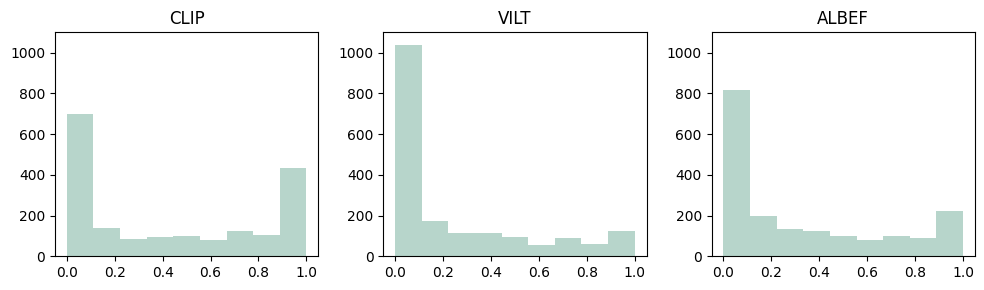

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for m, ax in zip(models, axes.flat):
    ax.hist(np.array(rec[m]), alpha=0.5, bins=np.linspace(0,1,10), label='Recall Values')
    ax.set_title(f'{m.upper()}')
    ax.set_ylim(0, 1100)
plt.tight_layout()
plt.show()

In [18]:
print('Number of features with more than 50% recall:\n')
for m in models:
    print(f'{m.upper()}: {torch.sum(rec[m] > .5)}')

Number of features with more than 50% recall:

CLIP: 778
VILT: 364
ALBEF: 525


In [19]:
sem_ft = get_fsk_features(project_path / 'dataset')
print('Top 10 features:')
for m in models:
    print(f'{m.upper()}: {[sem_ft[f] for f in rec[m].topk(10)[1].tolist()]}\n')

Top 10 features:
CLIP: ['used_by_paramedics', 'a_van', 'used_for_rescuing', 'used_by_hospitals', 'associated_with_polkas', 'used_for_emergencies', 'worn_by_cooks', 'used_for_cider', 'granny_smith', 'lives_in_Florida']

VILT: ['made_of_wicker', 'made_of_flowers', 'like_a_buffalo', 'has_sheets', 'made_by_bees', 'made_of_cardboard', 'a_cow', 'a_loaf', 'has_threads', 'has_pillows']

ALBEF: ['used_for_emergencies', 'used_by_playing', 'used_by_musicians', 'lives_in_a_colony', 'has_jaws', 'produces_honey', 'used_as_a_home_by_bees', 'made_by_bees', 'used_by_lumberjacks', 'worn_by_knights']



#### Coverage Error

In [20]:
for m in models:
    f_preds, f_labels = get_match(
        (project_path/'results'), m, synsets_imgs, center=True, m_type='Feature'
    )
    ce = coverage_error(torch.Tensor(f_preds), sem_ft_labels) / 1863
    print(f'Coverage error of {m.upper()} (%): {ce} \n')

Coverage error of CLIP (%): 0.5969449877738953 

Coverage error of VILT (%): 0.6503470540046692 

Coverage error of ALBEF (%): 0.6854996085166931 



#### Recall by feature type

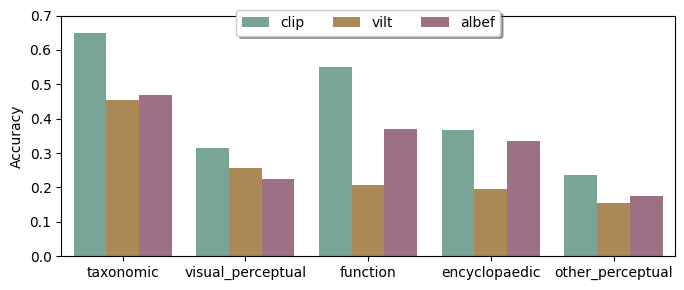

In [21]:
sem_ft_idx_by_type = {
    ft: list(set(fsk_info.loc[fsk_info['features_type']== ft]['features_idx'])) 
    for ft in feature_types if ft is not None
}

rec_f = []
for m in models:
    for f, f_idx in sem_ft_idx_by_type.items():
        f_mean = torch.mean(rec[m][f_idx]).detach().numpy()
        rec_f.append([m, f, f_mean])
rec_f = pd.DataFrame(rec_f, columns=['model', 'feature_type', 'recall'])
rec_f['recall'] = rec_f['recall'].astype(float)

fig, ax = plt.subplots(figsize=(7,3))
sns.barplot(
    x='feature_type', y='recall', hue='model', 
    data=rec_f, order=features_order, hue_order=models
)
ax.set(ylim=(0, 0.7))
ax.set(xlabel=None, ylabel='Accuracy')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=6, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

### 7) Are the detection of those semantic features related to the detection of a concept?

In [320]:
print(f'Correlation between concept distances and feature-based distances:')
for m in models:
    c_dist, c_labels = get_concept_match_distance(res_path, m, synsets_imgs, from_preds=True)
    f_dist, f_labels = get_feature_match_distance(res_path, m, synsets_imgs)
    corr, pval = spearmanr(c_dist, f_dist)
    print(f'{m.upper()}: correlation of {np.round(corr,3)}, pval of {np.round(pval,3)}')

Correlation between concept distances and feature-based distances:
CLIP: correlation of 0.245, pval of 0.0
VILT: correlation of 0.438, pval of 0.0
ALBEF: correlation of 0.078, pval of 0.0


In [82]:
sem_ft_type = {f: f_t for f, f_t in zip(fsk_info['features'], fsk_info['features_type'])}
synset_features = {s: fsk_info.loc[fsk_info['synsets'] == s]['features'].tolist() for s in synsets}

mi = {}
for m in models:
    mi_m = (
        pd.read_csv(res_path / 'mutual_info' / f'{m}.csv', index_col=0)
        .stack().to_frame().reset_index()
        .rename(columns={0: 'mutual information', 'level_0': 'synset', 'level_1': 'feature'})
    )
    mi_m
    mi_m['feature_type'] = mi_m['feature'].apply(lambda f: sem_ft_type[f])
    mi_m['sem_related'] = mi_m.apply(
        lambda row: True if row['feature'] in synset_features[row['synset']] else False,
        axis=1
    )
    mi_m = mi_m[['synset', 'feature', 'feature_type', 'sem_related', 'mutual information']]
    mi_m['remove'] = mi_m.apply(
        lambda row: True if row['synset'].split('-')[0] in row['feature'] else False,
        axis=1
    )
    mi_m = mi_m.drop(mi_m.loc[mi_m['remove']==True].index)
    mi_m = mi_m.drop('remove', axis=1)
    mi[m] = mi_m

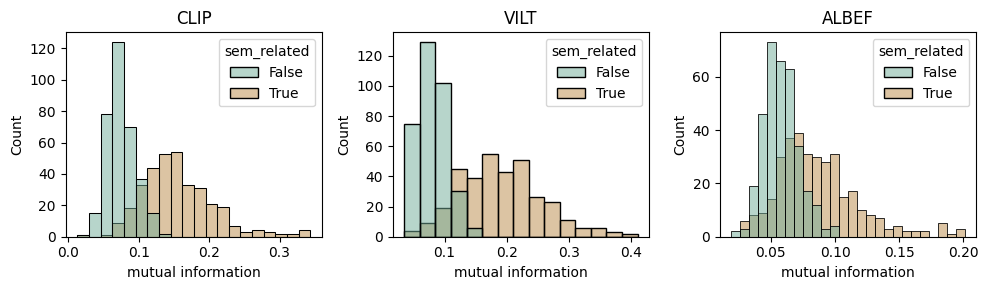

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for m, ax in zip(models, axes.flat):
    sns.histplot(
        data=mi[m].groupby(['sem_related', 'synset']).mean().reset_index(), 
        x='mutual information', hue='sem_related', ax=ax
    )
    ax.set_title(f'{m.upper()}')
plt.tight_layout()
plt.show()

In [131]:
mi_info = {}
for m in models:
    mean_info = mi[m].groupby(['sem_related']).mean().reset_index()
    mean_info['feature_type'] = 'all'
    mean_info = mean_info.set_index(['sem_related', 'feature_type'])
    mean_info = pd.concat([mean_info, mi[m].groupby(['sem_related', 'feature_type']).mean()]).unstack()
    mean_info.loc['sem_diff'] = mean_info.loc[True] - mean_info.loc[False] 
    mi_info[m] = mean_info.loc['sem_diff']
mi_info = pd.concat(mi_info)
mi_info = mi_info.unstack()
mi_info = mi_info.reset_index(level=1, drop=True)
mi_info = mi_info[['all'] + features_order]
mi_info

feature_type,all,taxonomic,visual_perceptual,function,encyclopaedic,other_perceptual
clip,0.080409,0.183772,0.062451,0.090132,0.063778,0.075858
vilt,0.112886,0.334404,0.079438,0.115077,0.093985,0.063202
albef,0.028491,0.076487,0.016045,0.035715,0.029582,0.019612


In [ ]:
m = 'albef'
sorted_data = mi[m].sort_values(by='mutual information', ascending=False)[:400]
sns.scatterplot(data=sorted_data, y='mutual information', x='match', hue='sem_related')
plt.show()

In [29]:
m = 'vilt'
s = synsets[2]
data = mi[m].loc[mi[m]['synset'] == s].sort_values(by='mutual information', ascending=False)[:10]
data

,synset,feature,feature_type,sem_related,mutual information,match
4332,alligator-n-02,a_fish,taxonomic,False,0.670343,1.654223
4379,alligator-n-02,a_bird,taxonomic,False,0.629269,1.103784
4486,alligator-n-02,howls,other_perceptual,False,0.535870,2.143642
3749,alligator-n-02,an_animal,taxonomic,True,0.525676,1.639077
4649,alligator-n-02,mallard,taxonomic,False,0.498193,1.650294
4177,alligator-n-02,has_horns,visual_perceptual,False,0.496846,1.371535
5066,alligator-n-02,has_a_large_beak,visual_perceptual,False,0.494047,1.222479
4659,alligator-n-02,like_a_snake,encyclopaedic,False,0.485544,2.352445
3910,alligator-n-02,a_mammal,taxonomic,False,0.484875,2.126367
5545,alligator-n-02,has_large_tusks,visual_perceptual,False,0.460454,1.337511


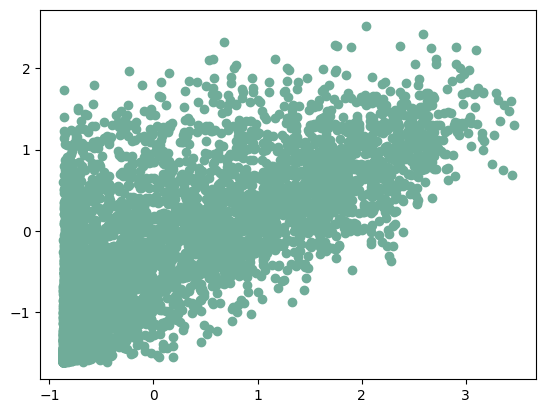

In [30]:
c_preds, _ = get_match((project_path/'results'), m, synsets_imgs, center=True,) 
f_preds, _ = get_match((project_path/'results'), m, synsets_imgs, center=True, m_type='Feature')

sem_ft_idx = get_feature_idx_map(project_path / 'dataset/annotations')
plt.scatter(c_preds[:,2], f_preds[:, sem_ft_idx['has_large_tusks']])
plt.show()

##### Plot mutual dependence

In [230]:
sem_ft_idx = get_feature_idx_map(project_path / 'dataset/annotations')

rel_info = {}
for m in models:
    c_preds, _ = get_match((project_path/'results'), m, synsets_imgs, center=True,) 
    f_preds, _ = get_match((project_path/'results'), m, synsets_imgs, center=True, m_type='Feature')
    m_data = []
    for s_i, s in enumerate(synsets):
        s_data = (
            mi[m].loc[mi[m]['synset'] == s]
            .sort_values(by='mutual information', ascending=False)[:200]
        )
        for idx, row in s_data.iterrows():
            f = row['feature']
            absent_vals = np.mean(c_preds[f_preds[:, sem_ft_idx[f]] < 0, s_i])
            present_vals = np.mean(c_preds[f_preds[:, sem_ft_idx[f]] > 0, s_i])
            m_data.append([s, f, row['feature_type'], absent_vals, present_vals])
    rel_info[m] = pd.DataFrame(
        m_data, columns=['synset', 'feature', 'feature_type', 'absent_vals', 'present_vals']
    )
rel_info = pd.concat(rel_info)

/Users/m_vilas/opt/miniconda3/envs/fsk/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/m_vilas/opt/miniconda3/envs/fsk/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


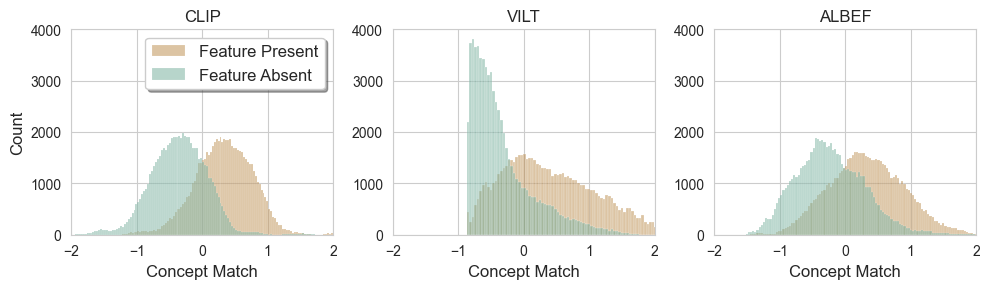

In [289]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for m, ax in zip(models, axes.flat):
    data = (
        rel_info.loc[m].set_index(['synset', 'feature', 'feature_type'])
        .stack().to_frame().reset_index()
        .rename(columns={'level_3':'feature_present', 0: 'concept_vals'})
    )
    sns.histplot(
        data=data, x='concept_vals', hue='feature_present', ax=ax, 
        legend=False
    )
    ax.set_title(f'{m.upper()}')
    ax.set_xlim(-2, 2)
    ax.set_ylim(0, 4000)
    ax.set_xlabel('Concept Match', size=12)
    ax.set_ylabel('Count', size=12)
axes[0].legend(
    #loc='right', 
    #bbox_to_anchor=(1.15, 0.7), 
    labels=['Feature Present', 'Feature Absent'],
    fontsize=12,
    #ncol=2, 
    fancybox=True, shadow=True
)
for ax in axes.flat[1:]:
    ax.set_ylabel(None)
plt.tight_layout()
plt.show()
fig.savefig(project_path / 'figures/ft_rel.png', dpi=300)